What boundary condition should I use to calculate the potential surface infiltration?  


### 1-D Richards equation solver code
- formulation based on a backward Euler implementation of the mixed theta-head formulation of the 1-D Richards equation, with a modified Picard iteration finite differencing solution scheme, with a modified Picard iteration finite differencing solution scheme.

- The soil water retention parameterization used is that of van Genuchten 
 [1980], and this code requires the corresponding MATLAB function        
 vanGenuchten.m.  
 
 - coordinate axis:  positive  downward
         z[-1] = 0  (top)
         z[0] = -100  (bottom)

In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time

In [2]:
%matplotlib inline

In [3]:
def vanGenuchten(h,phi) :
    alpha   = phi[0]
    theta_S = phi[1]
    theta_R = phi[2]
    n       = phi[3]
    m       = phi[4]
    Ksat    = phi[5] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R; 
    ## Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R)); 
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2; 
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2);
    try:
        for i in range(len(h)):
            if h[i] > 0:
                K[i] = Ksat
                C[i] = 0.
                theta[i] = theta_S
    except TypeError:
        if h > 0:
            K = Ksat
            C = 0.
            theta = theta_S
    return [C,K,theta]

In [4]:
# Define van Genuchten parameters
alpha   = 0.0335
theta_S = 0.368
theta_R = 0.102
lambdA  = 0.25
n       = lambdA + 1
m       = lambdA/n
Ksat    = 0.09

# Store van Genuchten parameters in array
phi = np.zeros(6)
phi[0] = alpha
phi[1] = theta_S
phi[2] = theta_R
phi[3] = n
phi[4] = m
phi[5] = Ksat

In [5]:
# set up grid 
dz = 1.; # [cm]
zmin = 0.; # [cm]
zmax = 100.; # [cm]
z = np.arange(zmin, zmax+1, dz)
nz   =  z.shape[0]

In [6]:
# Define matrices that we'll need in solution
BottomBoundCon = 1  # 0 = constant head, 1 = free drainage
DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
DeltaPlus[0,:] = 0
DeltaPlus[nz-1,:] = 0

DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
DeltaMinus[0,:] = 0
DeltaMinus[nz-1,:] = 0

MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
MPlus[0,0] = 2
MPlus[0,1:nz-1] = 0
MPlus[nz-1,nz-1] = 2
MPlus[nz-1,:nz-1] = 0  # not needed

MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
MMinus[0,0] = 2
MMinus[0,1:nz-1] = 0  # not needed
MMinus[nz-1,nz-1] = 2
MMinus[nz-1,:nz-1] = 0 

In [7]:
# Define time variables
stop_tol = 1e-5 # Stopping tolerance [cm]
dt  = 1 # [s]
tmin = 0. # [s]
tmax = 100 # [s]

t = np.arange(tmin, tmax + dt, dt)
nt = t.shape[0]

In [8]:
case = 'rain'

if case == 'drain':
    setflux = 1
    prate = 0.0
    hinit = -2.*np.ones(nz)
    fmtstr = 'dt={0}, tol={1}'.format(dt, stop_tol)
    
if case == 'rain':
    setflux = 1
    prate = -.001
    hinit = -1*np.ones(nz)
    fmtstr = 'dt={0}, tol={1}, p={2:.0e}'.format(dt, stop_tol, -prate)

if case == 'fixed_H':
    setflux = 0
    hinit = -1000*np.ones(nz)
    htop = -30.
    hinit[-1] = htop
#     hinit =   np.arange(nz)*5- 500; htop = hinit[-1]
    fmtstr = 'dt={0}, tol={1}, htop={2}'.format(dt, stop_tol, htop)

if case == 'equil':  
    # need to also adjust bottom boundary conditions to no flux for equilibrium
    setflux = 1
    flux = 0
    hinit = - np.arange(nz)/2 - 500
    htop = h[-1]
    fmtstr = 'dt={0}, tol={1}, htop={2}'.format(dt, stop_tol, htop)

In [9]:
if setflux == 1:
    [Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
    kt = (Kinit[-1] + Kinit[-2])/2.
    hinit[-1] = hinit[-2] - dz - prate*dz/kt

# use output from previous run?
# hinit = hnp1mp1

In [10]:
# Define a storage container to store the pressure heads and soil moistures
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
H = np.zeros([nz,nt])
K = np.zeros([nz,nt])
C = np.zeros([nz,nt])
H[:,0] = hinit
K[:,0] = Kinit
C[:,0] = Cinit

THETA = np.zeros([nz,nt])
THETA[:,0] = thetainit
ktop = np.zeros([ nt])
kbot = np.zeros([ nt])
error = np.zeros([nt])


In [11]:
 def timestep(hnp1m, thetan, setflux = True,  flux = prate):
    """
    """
    stop_flag = 0
    niter = 0
    while(stop_flag == 0):
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi)
        Cdiag = np.diag(cnp1m) 
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - 
                                          Kbarminus.dot(DeltaMinus)) 
        #  Compute the residual of MPFD (RHS)
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                               Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
             (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan); 
        # Compute deltam for iteration level m+1
        deltam = np.linalg.pinv(A).dot(R_MPFD)
        # Increment iteration counter and display number of iterations
        niter = niter + 1;
        if (max(abs(deltam[1:(nz-1)]))<stop_tol):
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam 
            hnp1mp1[0] = hnp1mp1[1]  # free drainage BC
            if setflux == 1:
                [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
                kt = (knp1m[-1] + knp1m[-2])/2.
                hnp1mp1[-1] =  hnp1mp1[-2] - dz - flux*dz/kt
#               [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            else:
                hnp1mp1[-1] = htop
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1
        else:        
            hnp1mp1 = hnp1m + deltam
            hnp1m = hnp1mp1
            hnp1m[0] = hnp1m[1] 
            if setflux == 1:
                [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi);
                kt = (knp1m[-1] + knp1m[-2])/2.
                hnp1m[-1] = hnp1m[-2] - dz - flux*dz/kt
            else:
                hnp1m[-1] = htop
    errornp1 =  np.sum(A.dot(deltam))*dt*dz
    return hnp1mp1,cnp1mp1,knp1mp1, thetanp1m, errornp1, niter

In [12]:
 def pot_infl(hnp1m, thetan, htop = -1):
    """
    """
    stop_flag = 0
    niter = 0
    while(stop_flag == 0):
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi)
        Cdiag = np.diag(cnp1m) 
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - 
                                          Kbarminus.dot(DeltaMinus)) 
        #  Compute the residual of MPFD (RHS)
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                               Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
             (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan); 
        # Compute deltam for iteration level m+1
        deltam = np.linalg.pinv(A).dot(R_MPFD)
        # Increment iteration counter and display number of iterations
        niter = niter + 1;
        if (max(abs(deltam[1:(nz-1)]))<stop_tol):
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam 
            hnp1mp1[0] = hnp1mp1[1]  # free drainage BC
            hnp1mp1[-1] = -1.
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1
            PI = (knp1mp1[-1] + knp1mp1[-2])/2.*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.)*dt
        else:
            hnp1mp1 = hnp1m + deltam
            hnp1m = hnp1mp1
            hnp1m[0] = hnp1m[1] 
            hnp1m[-1] = -1.
    return PI

In [13]:
start_time = time.time()
iterations = np.zeros([nt-1]);  # Define array for iteration counter

for i in range(1, nt):   # Initialize the Picard iteration solver
    if np.mod(i,10) == 0:
        print i, 'PI =  {0:.2f}cm/hr ; rain =  {1:.2f} cm/hr'.format(PI*3600,- prate*3600)
    hnp1m =  H[:,i-1]  
    thetan = THETA[:,i-1]
    PI = pot_infl(hnp1m, thetan)
#     print 'pot infl = ',  PI
    if  PI < abs(prate):
        flux = -PI
    else:
        flux = prate
    hnp1mp1,cnp1mp1,knp1mp1, thetanp1mp1,errornp1, niter = timestep(hnp1m,thetan, setflux = True,
                                                                 flux =   flux)

    THETA[:,i] = thetanp1mp1
    H[:,i] = hnp1mp1
    K[:, i]= knp1mp1
    C[:,i] = cnp1mp1
    kbot[i] =  (K[0, i] + K[1, i])/2.  
    ktop[i] =  (K[-1, i] + K[-2, i])/2.  
    error[i] = errornp1
#    error[i] = dz*np.sum(C[:,i]*deltam[:]) +  kbot[i]*(deltam[1] - deltam[0])*dt/dz \
#           ktop[i]*(deltam[-1] - deltam[-2])*dt/dz
    iterations[i-1] = niter

fluxin =    ktop*((H[-1] - H[-2])/dz + 1.)*dt   # top flux (cm)
fluxout = - kbot*((H[1] - H[0])/dz + 1. )*dt # bottom flux (cm)
newmass = (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 

print("--- %s seconds ---" % (time.time() - start_time))

10 PI =  564.36cm/hr ; rain =  3.60 cm/hr
20 PI =  832.87cm/hr ; rain =  3.60 cm/hr
30 PI =  1008.30cm/hr ; rain =  3.60 cm/hr
40 PI =  1136.44cm/hr ; rain =  3.60 cm/hr
50 PI =  1236.25cm/hr ; rain =  3.60 cm/hr
60 PI =  1317.30cm/hr ; rain =  3.60 cm/hr
70 PI =  1385.09cm/hr ; rain =  3.60 cm/hr
80 PI =  1443.04cm/hr ; rain =  3.60 cm/hr
90 PI =  1493.40cm/hr ; rain =  3.60 cm/hr
100 PI =  1537.75cm/hr ; rain =  3.60 cm/hr
--- 13.3336081505 seconds ---


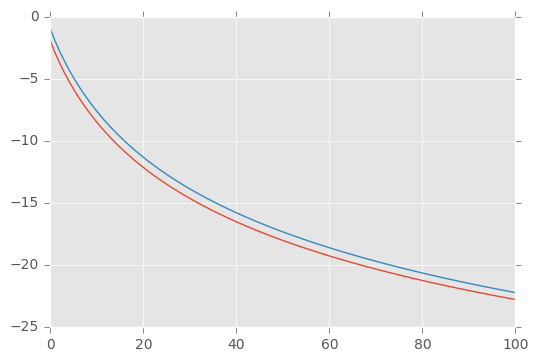

In [14]:
plt.plot(H[-1])
plt.plot(H[-2])

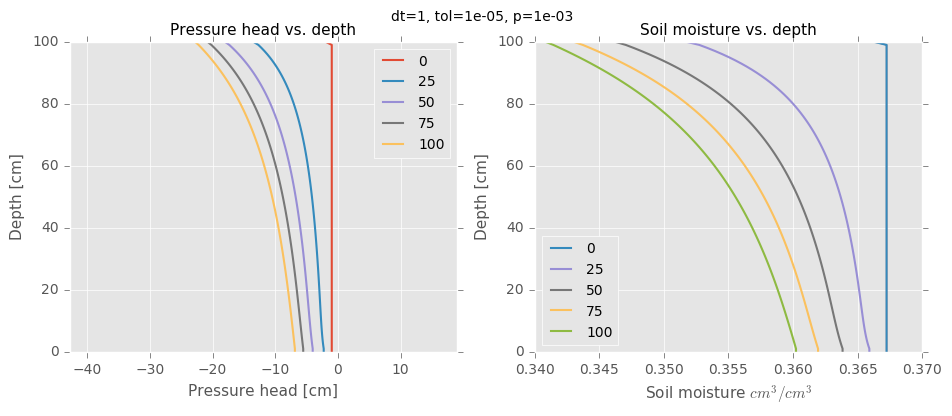

In [15]:
# 1. profile
fig = plt.figure(1, figsize = (11,4)); 
ax = plt.subplot(121)
plt.xlabel('Pressure head [cm]',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.xlim( np.min(H)-20,  np.max(H)+20)
plt.title('Pressure head vs. depth', fontsize=  11)

ax = plt.subplot(122)
plt.plot(thetainit,z)
plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.title('Soil moisture vs. depth',fontsize=  11)

for i in  range(0, len(t), len(t)/4):
    ax = plt.subplot(121)
    plt.plot(H[:, i],z, label = '{0:.0f}'.format(t[i]), lw = 1.5)
    plt.legend(loc = 'best', fontsize = 10)
    ax = plt.subplot(122)
    plt.plot(THETA[:, i],z, label = '{0:.0f}'.format(t[i]), lw = 1.5)
    plt.legend(loc = 'best', fontsize = 10)
    
plt.suptitle(fmtstr)
fig.savefig('case_{1}/profile {0}.pdf'.format(fmtstr, case))

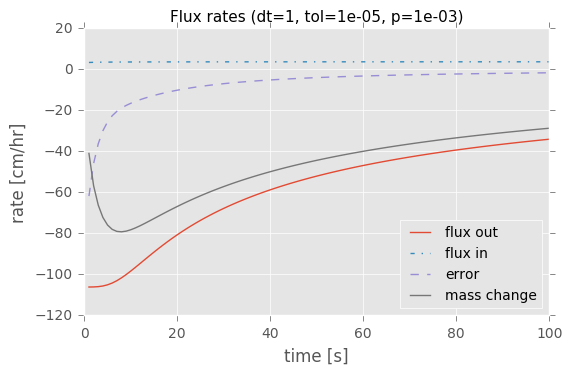

In [16]:
# 2. flux rates
fig = plt.figure(1, figsize = (6,3.7))

plt.title('Flux rates ({0})'.format(fmtstr), fontsize = 11)
plt.plot(t[1:], fluxout[1:]/dt*3600, label = 'flux out')
plt.plot(t[1:], fluxin[1:]/dt*3600, '-.', ms = 4, label = 'flux in')
plt.plot(t[1:], error[1:]/dt*3600, '--',  label = 'error')
plt.plot(t[1:], newmass/dt*3600, label = 'mass change')
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel('time [s]') 
plt.ylabel('rate [cm/hr]')
fig.savefig('case_{1}/flux rates {0}.pdf'.format(fmtstr, case) )

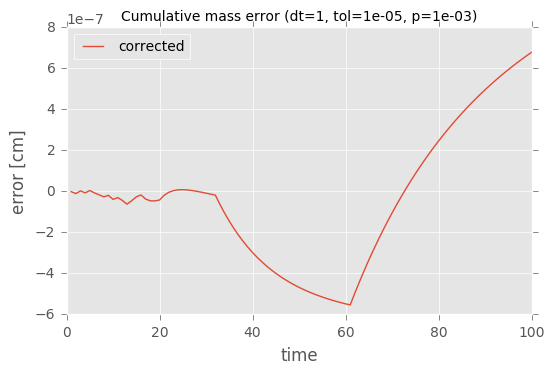

In [21]:
# 3.  cumulative error
fig = plt.figure(1, figsize = (6,3.7))
plt.title('Cumulative mass error ({0})'.format(fmtstr), fontsize = 10)
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:] - error[1:] ), label =  'corrected')
# plt.plot(t[1:], np.cumsum(fluxin[1:] -  newmass +fluxout[1:]  ), label = 'uncorrected')
plt.xlabel('time')
plt.ylabel('error [cm]')
plt.legend(loc = 'best', fontsize = 10)
fig.savefig('case_{1}/error {0}.pdf'.format(fmtstr, case))

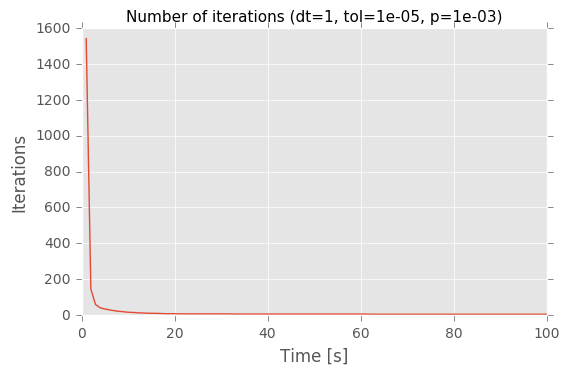

In [18]:
# 4. Number of iterations
fig = plt.figure(1, figsize = (6,3.7))
plt.plot(t[1:nt],iterations,'-')
plt.xlabel('Time [s]')
plt.title('Number of iterations ({0})'.format(fmtstr), fontsize = 11)
plt.ylabel('Iterations')
fig.savefig('case_{1}/iterations {0}.pdf'.format(fmtstr, case))

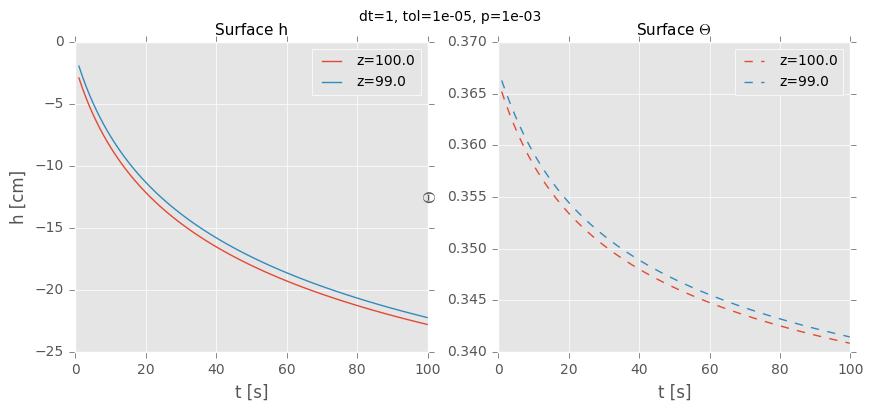

In [19]:
fig  = plt.figure(1, figsize = (10,4)); 
ax = plt.subplot(121)
plt.title('Surface h',  fontsize = 11)
plt.plot(t[1:], H[-1, 1:], label = 'z={}'.format(z[-1]))
plt.plot(t[1:], H[-2, 1:], label = 'z={}'.format(z[-2]))
plt.xlabel('t [s]'); plt.ylabel('h [cm]')
plt.legend(loc = 'best', fontsize = 10)
ax = plt.subplot(122)
plt.title('Surface $\Theta$',  fontsize = 11)
plt.plot(t[1:], THETA[-1, 1:], '--', label = 'z={}'.format(z[-1]))
plt.plot(t[1:], THETA[-2, 1:], '--', label = 'z={}'.format(z[-2]))
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel('t [s]'); plt.ylabel('$\Theta$')
plt.suptitle('{}'.format(fmtstr))
fig.savefig('case_{1}/surface_{0}.pdf'.format(fmtstr, case))